In [1]:
import cv2 #import the library 
import numpy as np

import matplotlib.pyplot as plt


import tensorflow as tf
from statistics import *
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array

cap = cv2.VideoCapture(0) # capture the webcam
cap.set(3, 640) ## define the dimensions
cap.set(4, 480)



Using TensorFlow backend.


True

In [2]:
def getContours(img,original_img):
    
    contours,hierachy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        
        area = cv2.contourArea(cnt)
       
        if area > 60000:
            cv2.drawContours(original_img,cnt,-1,(0,255,0),2)
            #print(area)
            
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            ax = approx.item(0)
            ay = approx.item(1)
            bx = approx.item(2)
            by = approx.item(3)
            cx = approx.item(4)
            cy = approx.item(5)
            dx = approx.item(6)
            dy = approx.item(7)
            
            width,height= 900,900

            pts1 = np.float32([[bx,by],[ax,ay],[cx,cy],[dx,dy]])
            pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])

            matrix = cv2.getPerspectiveTransform(pts1,pts2)
            img_perspective = cv2.warpPerspective(original_img,matrix,(width,height))
            img_corners = cv2.cvtColor(img_perspective,cv2.COLOR_BGR2GRAY)
            
            # Turn into a binary image
            for x in range(0, 900):
                for y in range(0, 900):
                    if img_corners[x][y]<100:
                        img_corners[x][y]=0
                    else:
                        img_corners[x][y]=255
                        
            cv2.imshow('Corners',img_corners)
            
            return img_corners
            
            #classify(img_corners)
            
      

In [3]:
def classify(Img):
     
    crop_val = 20
    digits_list = []

    
    
    for i in range(0, 9):
        for j in range(0, 9):
            
                
            J = j+1
            I = i+1
            cell = Img[I*100 - 100 + crop_val : I*100 - crop_val , J*100 - 100 + crop_val : J*100 - crop_val]

            img_canny = cv2.Canny(cell, 50, 50)

            contours, hierachy = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            
            
            digit = 0
            prob = 1.0

            for cnt in contours:
                area = cv2.contourArea(cnt)

                if area > 7.5:

                    peri = cv2.arcLength(cnt, True)
                    approx = cv2.approxPolyDP(cnt, 0.02*peri, True)

                    x,y,w,h = cv2.boundingRect(approx)

                    image_rect = cell[y:y+h, x:x+w]
                    image_rect = cv2.resize(image_rect, (100, 100))

                    image_num = img_to_array(image_rect)

                    image_num = np.array(image_num).reshape(-1, 100 , 100,1)
                    image_num = image_num.astype('float32')
                    image_num = image_num / 255.0

                    model = tf.keras.models.load_model('sudoku_model_ytb.h5')
                    digit = int(model.predict_classes(image_num))
                    prediction = model.predict(image_num)
                    prob = np.amax(prediction)
                    plt.imshow(image_rect, cmap='gray')
                    plt.show()
            print("Detected: ",digit)
            print("Probability: ",prob)
            digits_list.append(digit)
    return digits_list
                

In [4]:
def solve(grid):
    find = find_empty(grid)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if is_valid(grid, i, (row, col)):
            grid[row][col] = i

            if solve(grid):
                return True

            grid[row][col] = 0
        

    return False


def is_valid(grid, num, coordinate):
    # Check row
    for i in range(len(grid[0])):
        if grid[coordinate[0]][i] == num and coordinate[1] != i:
            return False

    # Check column
    for i in range(len(grid)):
        if grid[i][coordinate[1]] == num and coordinate[0] != i:
            return False

    # Check box
    box_x = coordinate[1] // 3
    box_y = coordinate[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if grid[i][j] == num and (i,j) != coordinate:
                return False

    return True




def find_empty(grid):
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 0:
                return (i, j)  # row, col

    return None

In [5]:
def save_sudoku(sudoku2d, sudoku2d_unsolved):
    
    solved_cell = np.ones((900, 900, 3))
    # Draw the sublines
    for i in range(8):
        solved_cell = cv2.line(solved_cell, ((i+1)*100, 0), ((i+1)*100, 900), (255, 255, 255), 5)
        solved_cell = cv2.line(solved_cell, (0,(i+1)*100), (900, (i+1)*100), (255, 255, 255), 5)
    # Draw the lines
    for i in range(2):
        solved_cell = cv2.line(solved_cell, ((i+1)*300, 0), ((i+1)*300, 900), (255, 255, 255), 10)
        solved_cell = cv2.line(solved_cell, (0,(i+1)*300), (900, (i+1)*300), (255, 255, 255), 10)




    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    thickness = 4
    for (index_row, row) in enumerate(sudoku2d):
        for (index_num, num) in enumerate(row):
            pos = (index_num*100 + 25, index_row*100 + 70)
            color = (200, 200, 200)
            if sudoku2d_unsolved[index_row][index_num] == 0:
                color = (0, 200, 0)
            
            solved_cell = cv2.putText(solved_cell ,str(num), pos, font, 
                           fontScale, color, thickness, cv2.LINE_AA)

    cv2.imwrite('solved.png', solved_cell)
    cv2.imshow('Solved',solved_cell)
    

Detected:  0
Probability:  1.0
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


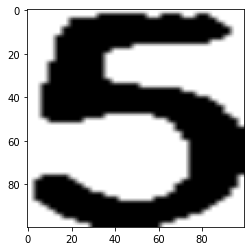

Detected:  5
Probability:  0.99992263
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


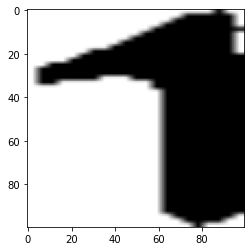

Detected:  1
Probability:  0.9656952
Detected:  0
Probability:  1.0


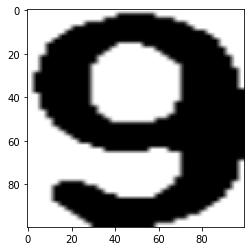

Detected:  9
Probability:  0.9999995


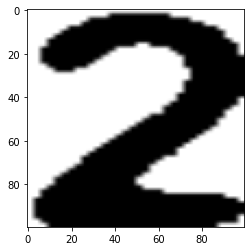

Detected:  2
Probability:  0.9946792
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


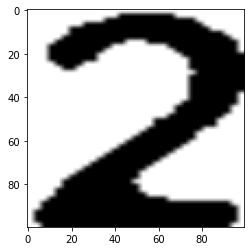

Detected:  2
Probability:  0.9986541
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


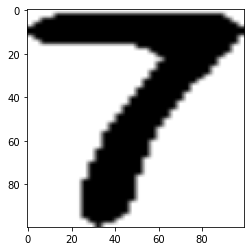

Detected:  7
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


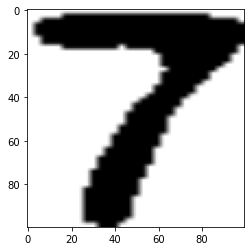

Detected:  7
Probability:  0.99999976
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


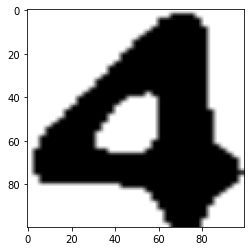

Detected:  4
Probability:  0.99999964
Detected:  0
Probability:  1.0


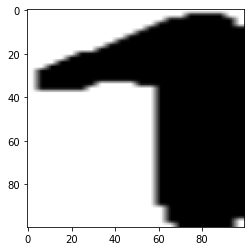

Detected:  1
Probability:  0.9902622


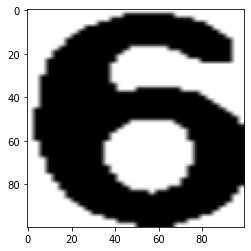

Detected:  6
Probability:  0.99496293
Detected:  0
Probability:  1.0


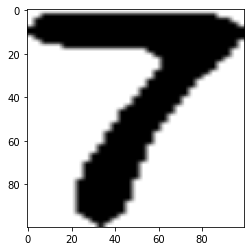

Detected:  7
Probability:  0.9999999
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


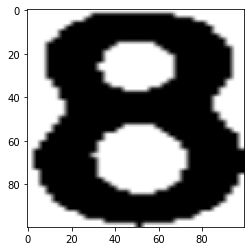

Detected:  8
Probability:  0.9899136


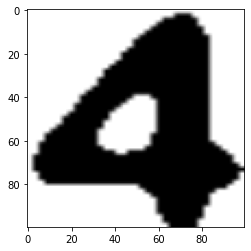

Detected:  4
Probability:  0.9999995
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


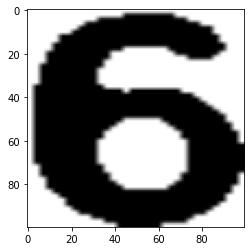

Detected:  6
Probability:  0.9993766


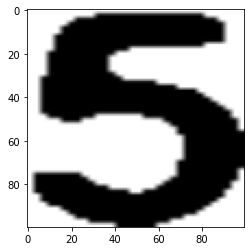

Detected:  5
Probability:  0.99999857


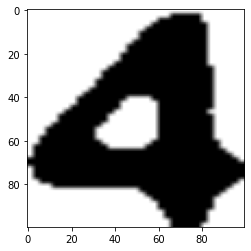

Detected:  4
Probability:  0.99999964
Detected:  0
Probability:  1.0


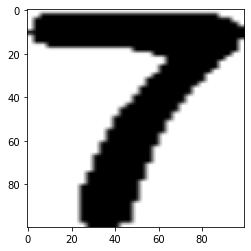

Detected:  7
Probability:  0.9999999


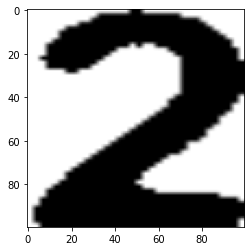

Detected:  2
Probability:  0.9733796


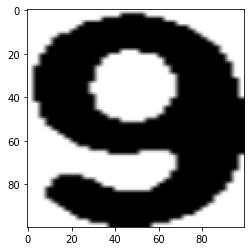

Detected:  9
Probability:  0.9999994
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


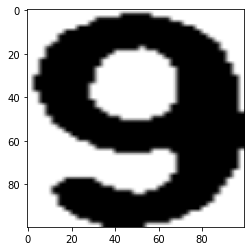

Detected:  9
Probability:  0.9999987


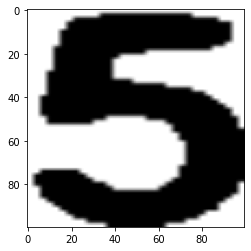

Detected:  5
Probability:  0.99999416
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


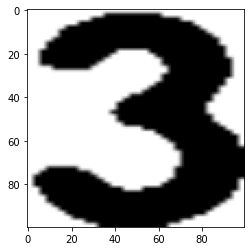

Detected:  3
Probability:  0.9986981
Detected:  0
Probability:  1.0


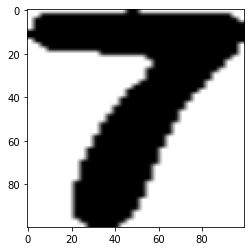

Detected:  7
Probability:  0.9999995


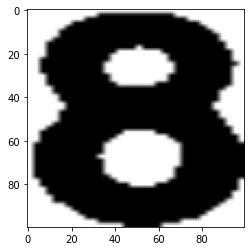

Detected:  8
Probability:  0.9374442
Detected:  0
Probability:  1.0


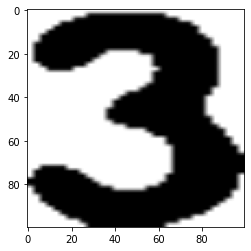

Detected:  3
Probability:  0.9993218
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


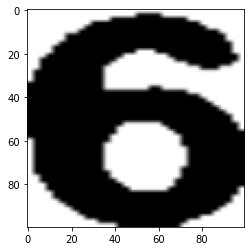

Detected:  6
Probability:  0.9984964
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


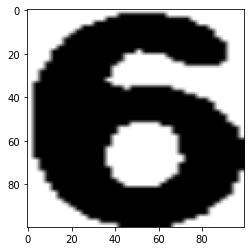

Detected:  6
Probability:  0.9729441
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


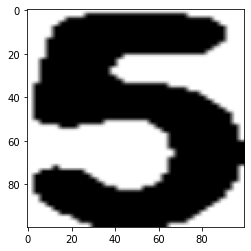

Detected:  5
Probability:  0.9999901
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


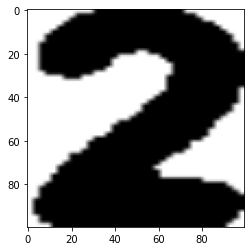

Detected:  2
Probability:  0.5901181


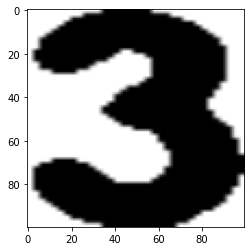

Detected:  3
Probability:  0.9902091
Detected:  0
Probability:  1.0


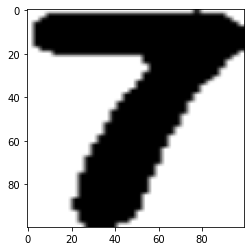

Detected:  7
Probability:  0.9999989
Detected:  0
Probability:  1.0
Detected:  0
Probability:  1.0


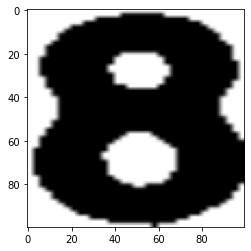

Detected:  8
Probability:  0.8475653
Detected:  0
Probability:  1.0
[[0 5 0 0 1 0 9 2 0]
 [0 0 0 2 0 0 7 0 0]
 [0 0 7 0 0 4 0 1 6]
 [0 7 0 0 0 8 4 0 0]
 [0 6 5 4 0 7 2 9 0]
 [0 0 9 5 0 0 0 3 0]
 [7 8 0 3 0 0 6 0 0]
 [0 0 6 0 0 5 0 0 0]
 [0 2 3 0 7 0 0 8 0]]


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [6]:
while True:
    success, img = cap.read()
    # Turning the original image to canny.
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),3)
    imgCanny = cv2.Canny(imgBlur,50,50)
    img_copy = img.copy()
    
    
    
    
    img_contours = img.copy()
    # Getting the countours
    img_contours_bin = getContours(imgCanny, img_copy)
    try:
        sudoku = classify(img_contours_bin)
        sudoku2d = []
        
        for i in range(0,9):
            sudoku2d.append([cell for cell in sudoku[i*9:(i+1)*9]])
            
        sudoku2d = np.array(sudoku2d)
        
        sudoku2d_unsolved = sudoku2d.copy()
        print(sudoku2d_unsolved)
        
        solve(sudoku2d)
        
        save_sudoku(sudoku2d, sudoku2d_unsolved)
    except:
        pass
    
    cv2.imshow('Webcam',img_copy)
    
    
    
    #cv2.imshow('Webcam',img_contours)
    if cv2.waitKey(1) & 0xff == ord('q'):
        cv2.destroyAllWindows()
        break
        